In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict, qualitycheck_trials, find_nearest_ind
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib widget

In [5]:
plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\EP_temporal_analysis'

#### Load excel sheet with metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

### Load subject

In [7]:
# data_loc = r"F:\psi_exp\mouse666194\pilot_aw_2023-02-22_12-32-58\experiment1\recording1" # DAY1
data_loc = r"F:\psi_exp\mouse666194\pilot_aw_psi_2023-02-23_10-40-34\experiment1\recording1" # DAY2

# data_loc = r"F:\psi_exp\mouse669118\pilot_aw_2023-03-23_12-14-39\experiment1\recording1" # DAY1
# data_loc = r"F:\psi_exp\mouse669118\pilot_aw_psi_2023-03-24_09-55-33\experiment1\recording1" # DAY2

# data_loc = r"F:\psi_exp\mouse669117\pilot_aw_2023-03-29_11-09-15\experiment1\recording1" # DAY1
# data_loc = r"F:\psi_exp\mouse669117\pilot_aw_psi_2023-03-30_11-37-07\experiment1\recording1" # DAY2

# data_loc = r"F:\psi_exp\mouse689242\aw_psi_2023-07-19_10-29-49\experiment1\recording1" # DAY1
# data_loc = r"F:\psi_exp\mouse689242\aw_iso_2023-07-20_10-52-57\experiment1\recording1" # DAY2

# data_loc = r"F:\psi_exp\mouse724057\aw_sal_2024-04-03_10-32-05\experiment1\recording1" # DAY1
# data_loc = r"F:\psi_exp\mouse724057\aw_psi_2024-04-04_10-35-18\experiment1\recording1" # DAY2

# data_loc = r"F:\psi_exp\mouse703064\aw_psi_2023-11-30_12-06-43\experiment1\recording1"

In [8]:
exp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print('{} - {}'.format(exp.mouse, exp_tag))

Experiment type: electrical stimulation
666194 - pilot_aw_psi


In [9]:
## Grab exp metadata from Templeton-log_exp ##
exp_meta = metadata[(
    (metadata['mouse_name'].str.contains(exp.mouse)) &
    (metadata['exp_name'].str.contains(data_loc[data_loc.find('mouse')+12:data_loc.find('experiment1')-4]))
)].squeeze()
## Get bad EEG channels ##
badchstr = exp_meta['EEG bad_channels'].replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))
print(bad_chs)
## Get injection times ##
try:
    inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
    print(inj_times)
except:
    inj_times = None

[]
[197.21, 763.06]


Re-check trial signal quality

Load stim log

In [10]:
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,good,mean_speed,resting_trial
0,biphasic,40,0.0004,1061.14291,1061.14331,0,True,0.000000,True
1,biphasic,40,0.0004,1064.75000,1064.75040,0,True,0.075932,False
2,biphasic,40,0.0004,1069.21232,1069.21272,0,True,0.113898,False
3,biphasic,40,0.0004,1072.71738,1072.71778,0,True,0.000000,True
4,biphasic,40,0.0004,1076.99273,1076.99313,0,True,7.441341,False


Load EEG all event traces

In [11]:
all_EEG_traces = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
good_chs = np.array([x for x in eeg_chs if x not in bad_chs])
print(len(good_chs))

30


Load and plot running and pupil

In [12]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

In [13]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
    # pupildf.head()

    pupilts = pupildf.sync_time.values
    pupilD = pupildf.Largest_Radius.values
    eyeD = pupildf.Eye_Diameter.values

    ## Smooth pupil diameter ##
    smooth_pupil = np.zeros_like(pupilD)
    k = 15 # filter window is actually k*2+1
    for i in range(k, len(pupilD)-k-1):
        smooth_pupil[i] = np.mean(pupilD[i-k:i+k]) # each point is the average of k surrounding points
    smooth_pupil[:k] = pupilD[:k]
    smooth_pupil[-k-1:] = pupilD[-k-1:]
    normpupil = smooth_pupil / np.mean(eyeD)
else:
    print('No local Pupileye*.csv file. Check server.')
    normpupil = None

## Investigate EPs

In [14]:
stim_log.tail()

,stim_type,parameter,duration,onset,offset,sweep,good,mean_speed,resting_trial
1195,biphasic,40,0.0004,8682.95676,8682.95716,9,True,21.048364,False
1196,biphasic,40,0.0004,8686.57460,8686.57500,9,True,40.479375,False
1197,biphasic,40,0.0004,8690.37170,8690.37210,9,True,43.592589,False
1198,biphasic,40,0.0004,8694.19090,8694.19130,9,True,40.122495,False
1199,biphasic,40,0.0004,8698.11549,8698.11589,9,True,35.513419,False


In [15]:
np.unique(stim_log['parameter'].values)

array(['40'], dtype=object)

In [16]:
print('{:d} good trials out of {:d} total'.format(np.sum(stim_log.good.values), len(stim_log)))
print('{:d} resting trials out of {:d} total'.format(np.sum(stim_log.resting_trial.values), len(stim_log)))

1198 good trials out of 1200 total
659 resting trials out of 1200 total


In [17]:
evtype = 'biphasic'
evpar = '40'

event_inds = get_events_wdict(stim_log, {'stim_type': evtype, 'parameter': evpar}, out='index')
event_traces = all_EEG_traces[:, :, event_inds]
## Apply common average reference ##
event_traces = event_traces - np.mean(event_traces[:, good_chs, :], axis=1)[:,None,:]

resting_trials = stim_log['resting_trial'].values[event_inds]
total_stims = len(get_events_wdict(stim_log, {'stim_type': evtype}, out='index'))

In [18]:
event_traces.shape

(10000, 30, 1200)

Global field power across chs

Rectified amplitude - a la Simone

Should we do [mean(trials) -> abs(values) -> mean(chs)] or [abs(values) -> mean(trials) -> mean(chs)]?
<br>**mean(trials) -> abs(values) -> mean(chs)**
<br>Then Simone takes the average value within the component window (can take the max also, will see the same trend).

## EEG metrics for trial sets

In [19]:
n_mean = 10

comp_dict = {'early': [0.003, 0.05], 'late': [0.15, 0.25], 'baseline': [-0.2, -0.1]}
compinfo = {'early': ['r', 'o'], 'mid': ['g', 's'], 'late': ['b', 'v'], 'baseline': ['gray', '<']}

# comp_dict = {'early': [0.003, 0.02], 'earlySR': [0.003, 0.05], 'mid': [0.08, 0.2], 'lateSR': [0.15, 0.25]}
# compinfo = {'early': ['darkviolet', 'P'], 'earlySR': ['r', 'o'], 'mid': ['g', 's'], 'lateSR': ['b', 'v']}

PCI_params = {
    'baseline_window': (-0.8, -0.002), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.002, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.1, # my default: 1.1, used 1.6 for eLife paper?
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

In [20]:
# mean(trials) -> abs(values) -> mean(chs) #
## Average across every n_mean trials ##
if event_traces.shape[2] % n_mean == 0:
    num_trial_sets = int(event_traces.shape[2] / n_mean)
    n_mean_traces = np.mean(event_traces.reshape((event_traces.shape[0], event_traces.shape[1], -1, n_mean)), axis=-1)
    n_rest_trials = np.sum(resting_trials.reshape((-1, n_mean)), axis=-1)
else:
    print('Number of trials is not divisible by n_mean.')
## Then find mean across chs of the absolute value of trial averages ##
rect_mean = np.mean(np.abs(n_mean_traces[:, good_chs, :]), axis=1)

## METRICS ##
EP_metrics = {}
EP_metrics['n_rest_trials'] = n_rest_trials
EP_metrics['n_run_trials'] = n_mean - n_rest_trials
## Get rectified mean amplitude within test windows ##
for wini, windowi in comp_dict.items():
    testinds = np.nonzero((EEG_event_timestamps >= windowi[0]) & (EEG_event_timestamps <= windowi[1]))[0]
    mean_amp = np.mean(rect_mean[testinds, :], axis=0)
    EP_metrics[wini + '_mean_amp'] = mean_amp

## PCI ##
print('Calculating PCI...')
PCIvals = []
for mi in range(num_trial_sets):
    PCIvals.append(calc_PCIst(n_mean_traces[:,:,mi][:, good_chs].T, EEG_event_timestamps, **PCI_params))
EP_metrics['PCIst'] = PCIvals
print('Done :)')
    
EP_metrics_df = pd.DataFrame(EP_metrics)
EP_metrics_df.head()

Calculating PCI...
Done :)


,n_rest_trials,n_run_trials,early_mean_amp,late_mean_amp,baseline_mean_amp,PCIst
0,3,7,47.012461,52.263438,9.797096,77.134236
1,10,0,42.274621,62.342354,9.141829,69.550977
2,10,0,37.185750,59.833612,8.319176,58.135739
3,7,3,30.858333,32.985445,8.604013,57.063759
4,7,3,33.818348,46.944881,6.761362,74.235789


### Make combo summary plot

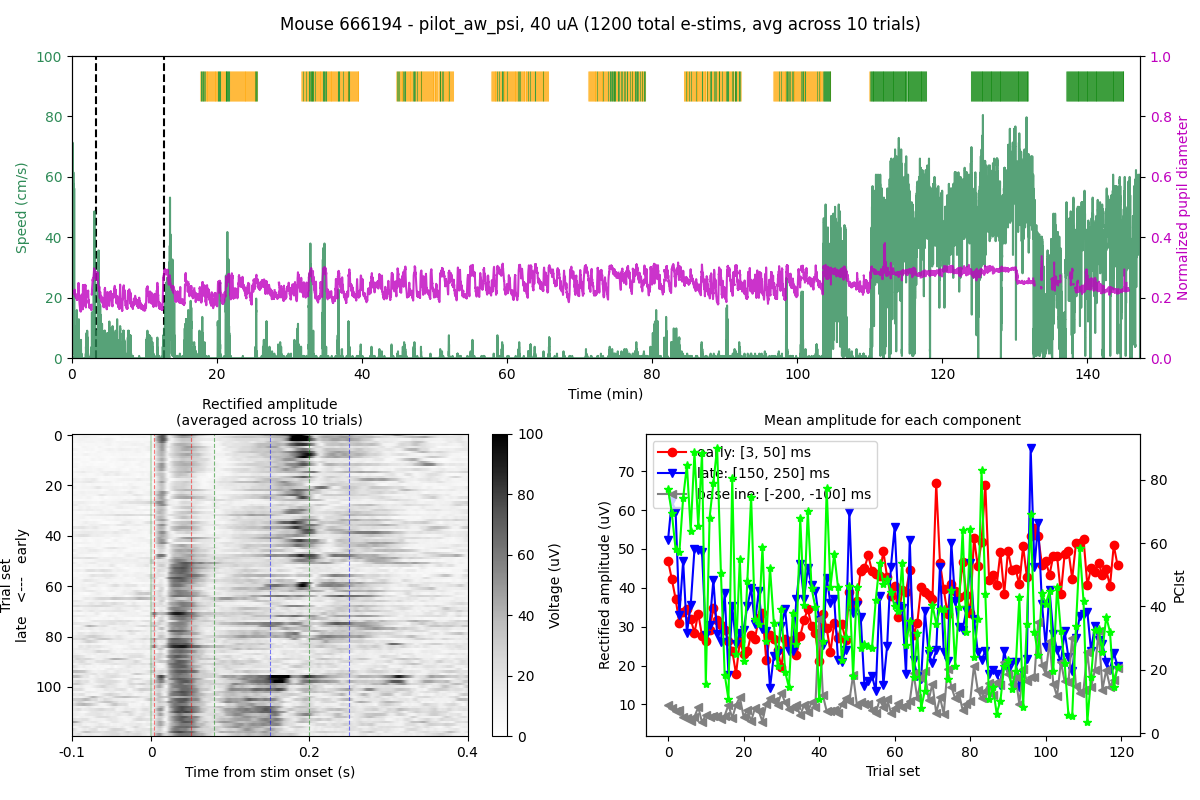

In [21]:
pwin = [-0.1, 0.4]
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(nrows=2, ncols=2, left=0.06, right=0.95, top=0.93, bottom=0.08, hspace=0.25, wspace=0.16)

axsp = fig.add_subplot(gs[0,:])
axim = fig.add_subplot(gs[1,0])
axamp = fig.add_subplot(gs[1,1])

## Plot speed, pupil, and estim times ##
if inj_times is not None:
    for itime in inj_times:
        axsp.axvline(itime/60, color='k', linestyle='dashed')

axsp.plot(speedts/60, speed, 'seagreen', alpha=0.8)
axsp.set_xlim([speedts[0]/60, speedts[-1]/60])
axsp.set_xlabel('Time (min)')
axsp.set_ylabel('Speed (cm/s)', color='seagreen')
axsp.tick_params(axis='y', labelcolor='seagreen')
axsp.set_ylim([0, 100])
        
axpup = axsp.twinx()
if normpupil is not None:
    axpup.plot(pupilts/60, normpupil, 'm', alpha=0.8)
    axpup.set_ylabel('Normalized pupil diameter', color='m')
    axpup.tick_params(axis='y', labelcolor='m')
axpup.set_ylim([0, 1])

for rboo, rcol in zip([True, False], ['orange', 'green']):
    stimtimes = stim_log[(stim_log['stim_type'] == 'biphasic') & (stim_log['resting_trial'] == rboo)].onset.values / 60
    axpup.eventplot(stimtimes, colors=rcol, lineoffsets=0.9, linelengths=0.1, linewidths=0.75, alpha=0.5)
    
## Plot trial set rectified average EPs ##
pwinind = [find_nearest_ind(EEG_event_timestamps, x) for x in pwin]
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0), color='g', alpha=0.2)
vim = axim.imshow(rect_mean.T, cmap='Greys', interpolation='none', aspect='auto', vmin=0, vmax=100)
## Add Simone's windows ##
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.003), color='r', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.05), color='r', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.08), color='g', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.2), color='g', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.15), color='b', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.25), color='b', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.set_xlim(pwinind)
new_ticks = [pwin[0], 0, np.mean([0, pwin[1]]), pwin[1]]
axim.set_xticks([find_nearest_ind(EEG_event_timestamps, x) for x in new_ticks])
axim.set_xticklabels(new_ticks)
axim.set_xlabel('Time from stim onset (s)')
axim.set_ylabel('Trial set\nlate   <---   early')
axim.set_title('Rectified amplitude\n(averaged across {:d} trials)'.format(n_mean))
cb = fig.colorbar(vim, label='Voltage (uV)', ax=axim)

## Plot EP component amplitudes ##
axpci = axamp.twinx()
axpci.plot(EP_metrics_df['PCIst'].values, color='lime', marker='*')
axpci.set_ylabel('PCIst')
# axbar.bar(EP_metrics_df.index.values, EP_metrics_df['n_rest_trials'].values, color='orange', alpha=0.2)
# axbar.set_ylim([0, n_mean])
for ii, (wini, windowi) in enumerate(comp_dict.items()):
    axamp.plot(
        EP_metrics_df[wini + '_mean_amp'].values, color=compinfo[wini][0], marker=compinfo[wini][1],
        label='{}: [{:d}, {:d}] ms'.format(wini, int(windowi[0]*1e3), int(windowi[1]*1e3))
    )

axamp.set_title('Mean amplitude for each component')#.format(wini, int(windowi[0]*1e3), int(windowi[1]*1e3)))
axamp.set_xlabel('Trial set')
axamp.set_ylabel('Rectified amplitude (uV)')
axamp.legend()
# axbar.set_ylabel('Number of REST trials')

fig.suptitle('Mouse {} - {}, {} uA ({:d} total e-stims, avg across {:d} trials)'.format(exp.mouse, exp_tag, evpar, total_stims, n_mean))

## Save ##
figname = '{}-{}_allEPsmetrics{}_{:d}avg.png'.format(exp.mouse, exp_tag, evpar, n_mean)
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

Comparing individual trial sets